In [ ]:
%matplotlib inline


# Speech Command Classification with torchaudio

This tutorial will show you how to correctly format an audio dataset and
then train/test an audio classifier network on the dataset.

Colab has GPU option available. In the menu tabs, select “Runtime” then
“Change runtime type”. In the pop-up that follows, you can choose GPU.
After the change, your runtime should automatically restart (which means
information from executed cells disappear).

First, let’s import the common torch packages such as
[torchaudio](https://github.com/pytorch/audio)_ that can be installed
by following the instructions on the website.


In [ ]:
# Uncomment the line corresponding to your "runtime type" to run in Google Colab

# CPU:
# !pip install pydub torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# GPU:
# !pip install pydub torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip install pydub torch==1.13.1+cu117 torchvision==0.14.1+cu117 torchaudio==0.13.1 --extra-index-url https://download.pytorch.org/whl/cu117


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys

import matplotlib.pyplot as plt
import IPython.display as ipd

from tqdm import tqdm

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu117
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 GB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.3/24.3 MB 64.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 81.3 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.4.0+cu121
    Uninstalling torch-2.4.0+cu121:
      Successfully uninstalled torch-2.4.0+cu121
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.19.0+cu121
    Uninstalling torchvision-0.19.0+cu121:
      Successfully uninstalled torchvision-0.19.0+cu121
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 2.4.0+cu121
    Uninstalling torchaudio-2.4.0+cu121:
      Successfully uninstalled torchaudio-2.4.0+cu121


Let’s check if a CUDA GPU is available and select our device. Running
the network on a GPU will greatly decrease the training/testing runtime.




In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Importing the Dataset

We use torchaudio to download and represent the dataset. Here we use
[SpeechCommands](https://arxiv.org/abs/1804.03209)_, which is a
datasets of 35 commands spoken by different people. The dataset
``SPEECHCOMMANDS`` is a ``torch.utils.data.Dataset`` version of the
dataset. In this dataset, all audio files are about 1 second long (and
so about 16000 time frames long).

The actual loading and formatting steps happen when a data point is
being accessed, and torchaudio takes care of converting the audio files
to tensors. If one wants to load an audio file directly instead,
``torchaudio.load()`` can be used. It returns a tuple containing the
newly created tensor along with the sampling frequency of the audio file
(16kHz for SpeechCommands).

Going back to the dataset, here we create a subclass that splits it into
standard training, validation, testing subsets.




In [ ]:
from torchaudio.datasets import SPEECHCOMMANDS
import os


class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]


# Create training and testing split of the data. We do not use validation in this tutorial.
train_set = SubsetSC("training")
test_set = SubsetSC("testing")

waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]

  0%|          | 0.00/2.26G [00:00<?, ?B/s]

A data point in the SPEECHCOMMANDS dataset is a tuple made of a waveform
(the audio signal), the sample rate, the utterance (label), the ID of
the speaker, the number of the utterance.




Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


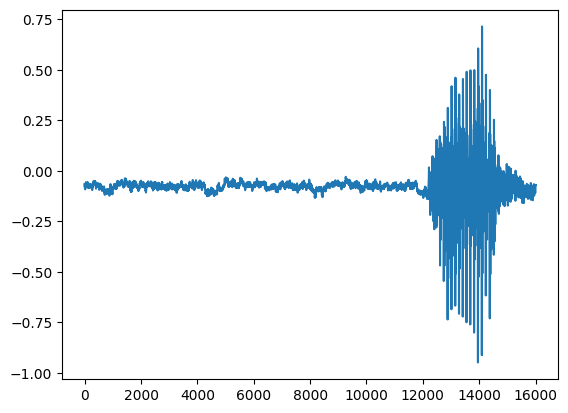

In [ ]:
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy());

Let’s find the list of labels available in the dataset.




In [ ]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
labels

['backward',
 'bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'follow',
 'forward',
 'four',
 'go',
 'happy',
 'house',
 'learn',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'visual',
 'wow',
 'yes',
 'zero']

The 35 audio labels are commands that are said by users. The first few
files are people saying “marvin”.




In [ ]:
waveform_first, *_ = train_set[0]
ipd.Audio(waveform_first.numpy(), rate=sample_rate)

waveform_second, *_ = train_set[1]
ipd.Audio(waveform_second.numpy(), rate=sample_rate)

The last file is someone saying “visual”.




In [ ]:
waveform_last, *_ = train_set[-1]
ipd.Audio(waveform_last.numpy(), rate=sample_rate)

## Formatting the Data

This is a good place to apply transformations to the data. For the
waveform, we downsample the audio for faster processing without losing
too much of the classification power.

We don’t need to apply other transformations here. It is common for some
datasets though to have to reduce the number of channels (say from
stereo to mono) by either taking the mean along the channel dimension,
or simply keeping only one of the channels. Since SpeechCommands uses a
single channel for audio, this is not needed here.




In [ ]:
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform)

ipd.Audio(transformed.numpy(), rate=new_sample_rate)

We are encoding each word using its index in the list of labels.




In [ ]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

yes --> tensor(33) --> yes


To turn a list of data point made of audio recordings and utterances
into two batched tensors for the model, we implement a collate function
which is used by the PyTorch DataLoader that allows us to iterate over a
dataset by batches. Please see [the
documentation](https://pytorch.org/docs/stable/data.html#working-with-collate-fn)_
for more information about working with a collate function.

In the collate function, we also apply the resampling, and the text
encoding.




In [ ]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 256

if device == "cuda":
    num_workers = 16
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

## Define the Network

For this tutorial we will use a convolutional neural network to process
the raw audio data. Usually more advanced transforms are applied to the
audio data, however CNNs can be used to accurately process the raw data.
The specific architecture is modeled after the M5 network architecture
described in [this paper](https://arxiv.org/pdf/1610.00087.pdf)_. An
important aspect of models processing raw audio data is the receptive
field of their first layer’s filters. Our model’s first filter is length
80 so when processing audio sampled at 8kHz the receptive field is
around 10ms (and at 4kHz, around 20 ms). This size is similar to speech
processing applications that often use receptive fields ranging from
20ms to 40ms.




In [ ]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)


model = M5(n_input=transformed.shape[0], n_output=len(labels))
model.to(device)
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=35, bias=True)
)
Numbe

We will use the same optimization technique used in the paper, an Adam
optimizer with weight decay set to 0.0001. At first, we will train with
a learning rate of 0.01, but we will use a ``scheduler`` to decrease it
to 0.001 during training after 20 epochs.




In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

## Training and Testing the Network

Now let’s define a training function that will feed our training data
into the model and perform the backward pass and optimization steps. For
training, the loss we will use is the negative log-likelihood. The
network will then be tested after each epoch to see how the accuracy
varies during the training.




In [ ]:
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data.contiguous()) # Ensure data is contiguous before applying transform

        data = data.mean(dim=1, keepdim=True)

        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())

Now that we have a training function, we need to make one for testing
the networks accuracy. We will set the model to ``eval()`` mode and then
run inference on the test dataset. Calling ``eval()`` sets the training
variable in all modules in the network to false. Certain layers like
batch normalization and dropout layers behave differently during
training so this step is crucial for getting correct results.




In [ ]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data.contiguous())

        data = data.mean(dim=1, keepdim=True)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(pbar_update)

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")

Finally, we can train and test the network. We will train the network
for ten epochs then reduce the learn rate and train for ten more epochs.
The network will be tested after each epoch to see how the accuracy
varies during the training.




In [ ]:
log_interval = 20
n_epoch = 8

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        test(model, epoch)
        scheduler.step()



  0%|          | 0.0026666666666666666/8 [00:07<6:05:34, 2742.77s/it]

Train Epoch: 1 [0/84843 (0%)]	Loss: 3.782197


  1%|          | 0.05866666666666665/8 [00:11<10:11, 76.95s/it]

Train Epoch: 1 [5120/84843 (6%)]	Loss: 3.017475


  1%|▏         | 0.10933333333333328/8 [00:15<09:32, 72.53s/it]

Train Epoch: 1 [10240/84843 (12%)]	Loss: 2.536010


  2%|▏         | 0.16266666666666676/8 [00:19<09:34, 73.29s/it]

Train Epoch: 1 [15360/84843 (18%)]	Loss: 2.286800


  3%|▎         | 0.21600000000000033/8 [00:23<10:08, 78.12s/it]

Train Epoch: 1 [20480/84843 (24%)]	Loss: 2.173287


  3%|▎         | 0.2693333333333337/8 [00:28<10:23, 80.67s/it] 

Train Epoch: 1 [25600/84843 (30%)]	Loss: 1.868586


  4%|▍         | 0.32533333333333336/8 [00:32<09:39, 75.56s/it]

Train Epoch: 1 [30720/84843 (36%)]	Loss: 1.758817


  5%|▍         | 0.3786666666666664/8 [00:36<09:10, 72.29s/it]

Train Epoch: 1 [35840/84843 (42%)]	Loss: 1.749150


  5%|▌         | 0.42933333333333273/8 [00:40<09:30, 75.35s/it]

Train Epoch: 1 [40960/84843 (48%)]	Loss: 1.590029


  6%|▌         | 0.4853333333333324/8 [00:44<09:05, 72.53s/it] 

Train Epoch: 1 [46080/84843 (54%)]	Loss: 1.548656


  7%|▋         | 0.5386666666666662/8 [00:48<08:45, 70.46s/it]

Train Epoch: 1 [51200/84843 (60%)]	Loss: 1.342996


  7%|▋         | 0.5893333333333336/8 [00:52<09:41, 78.50s/it]

Train Epoch: 1 [56320/84843 (66%)]	Loss: 1.497951


  8%|▊         | 0.6426666666666677/8 [00:56<13:38, 111.27s/it]

Train Epoch: 1 [61440/84843 (72%)]	Loss: 1.446984


  9%|▊         | 0.6960000000000018/8 [01:01<09:16, 76.16s/it]

Train Epoch: 1 [66560/84843 (78%)]	Loss: 1.243515


  9%|▉         | 0.749333333333336/8 [01:05<10:10, 84.25s/it] 

Train Epoch: 1 [71680/84843 (84%)]	Loss: 1.190354


 10%|█         | 0.8026666666666701/8 [01:09<09:14, 76.97s/it]

Train Epoch: 1 [76800/84843 (90%)]	Loss: 1.219558


 11%|█         | 0.8560000000000042/8 [01:14<09:28, 79.54s/it]

Train Epoch: 1 [81920/84843 (96%)]	Loss: 1.065375


 13%|█▎        | 1.0053333333333394/8 [01:27<13:08, 112.66s/it]


Test Epoch: 1	Accuracy: 6994/11005 (64%)

Train Epoch: 2 [0/84843 (0%)]	Loss: 1.034406


 13%|█▎        | 1.0586666666666713/8 [01:29<04:30, 38.96s/it]

Train Epoch: 2 [5120/84843 (6%)]	Loss: 1.015881


 14%|█▍        | 1.1146666666666698/8 [01:31<03:22, 29.39s/it]

Train Epoch: 2 [10240/84843 (12%)]	Loss: 1.008752


 15%|█▍        | 1.1680000000000017/8 [01:32<03:12, 28.15s/it]

Train Epoch: 2 [15360/84843 (18%)]	Loss: 1.029832


 15%|█▌        | 1.2213333333333336/8 [01:34<03:06, 27.54s/it]

Train Epoch: 2 [20480/84843 (24%)]	Loss: 0.838010


 16%|█▌        | 1.2746666666666655/8 [01:35<03:05, 27.53s/it]

Train Epoch: 2 [25600/84843 (30%)]	Loss: 0.967088


 17%|█▋        | 1.3279999999999974/8 [01:37<03:09, 28.43s/it]

Train Epoch: 2 [30720/84843 (36%)]	Loss: 0.966265


 17%|█▋        | 1.3813333333333293/8 [01:38<03:04, 27.80s/it]

Train Epoch: 2 [35840/84843 (42%)]	Loss: 0.815060


 18%|█▊        | 1.4346666666666612/8 [01:40<03:03, 27.96s/it]

Train Epoch: 2 [40960/84843 (48%)]	Loss: 0.953172


 19%|█▊        | 1.48266666666666/8 [01:41<03:51, 35.46s/it]  

Train Epoch: 2 [46080/84843 (54%)]	Loss: 0.980906


 19%|█▉        | 1.541333333333325/8 [01:43<03:13, 30.00s/it] 

Train Epoch: 2 [51200/84843 (60%)]	Loss: 0.974236


 20%|█▉        | 1.594666666666657/8 [01:45<02:56, 27.59s/it] 

Train Epoch: 2 [56320/84843 (66%)]	Loss: 0.937820


 21%|██        | 1.6479999999999888/8 [01:46<02:59, 28.26s/it]

Train Epoch: 2 [61440/84843 (72%)]	Loss: 0.884162


 21%|██▏       | 1.7013333333333207/8 [01:48<02:54, 27.65s/it]

Train Epoch: 2 [66560/84843 (78%)]	Loss: 0.775445


 22%|██▏       | 1.7546666666666526/8 [01:49<02:51, 27.46s/it]

Train Epoch: 2 [71680/84843 (84%)]	Loss: 0.919609


 23%|██▎       | 1.8079999999999845/8 [01:51<02:56, 28.53s/it]

Train Epoch: 2 [76800/84843 (90%)]	Loss: 0.995301


 23%|██▎       | 1.8613333333333164/8 [01:52<02:50, 27.79s/it]

Train Epoch: 2 [81920/84843 (96%)]	Loss: 0.825088


 25%|██▌       | 2.002666666666646/8 [01:57<02:55, 29.25s/it] 


Test Epoch: 2	Accuracy: 8014/11005 (73%)

Train Epoch: 3 [0/84843 (0%)]	Loss: 0.816354


 26%|██▌       | 2.061333333333316/8 [01:59<02:48, 28.34s/it] 

Train Epoch: 3 [5120/84843 (6%)]	Loss: 0.983707


 26%|██▋       | 2.1146666666666523/8 [02:00<02:40, 27.30s/it]

Train Epoch: 3 [10240/84843 (12%)]	Loss: 0.894744


 27%|██▋       | 2.1679999999999886/8 [02:02<02:49, 29.10s/it]

Train Epoch: 3 [15360/84843 (18%)]	Loss: 0.892004


 28%|██▊       | 2.221333333333325/8 [02:03<02:40, 27.76s/it] 

Train Epoch: 3 [20480/84843 (24%)]	Loss: 0.823622


 28%|██▊       | 2.2746666666666613/8 [02:05<02:42, 28.36s/it]

Train Epoch: 3 [25600/84843 (30%)]	Loss: 0.939119


 29%|██▉       | 2.322666666666664/8 [02:06<03:25, 36.27s/it] 

Train Epoch: 3 [30720/84843 (36%)]	Loss: 0.937809


 30%|██▉       | 2.381333333333334/8 [02:08<02:41, 28.73s/it] 

Train Epoch: 3 [35840/84843 (42%)]	Loss: 0.861133


 30%|███       | 2.4346666666666703/8 [02:10<02:36, 28.05s/it]

Train Epoch: 3 [40960/84843 (48%)]	Loss: 0.832437


 31%|███       | 2.4880000000000067/8 [02:11<02:35, 28.14s/it]

Train Epoch: 3 [46080/84843 (54%)]	Loss: 0.853064


 32%|███▏      | 2.541333333333343/8 [02:13<02:30, 27.55s/it] 

Train Epoch: 3 [51200/84843 (60%)]	Loss: 0.806253


 32%|███▏      | 2.5946666666666793/8 [02:14<02:31, 28.10s/it]

Train Epoch: 3 [56320/84843 (66%)]	Loss: 0.853721


 33%|███▎      | 2.6480000000000157/8 [02:16<02:27, 27.63s/it]

Train Epoch: 3 [61440/84843 (72%)]	Loss: 0.754603


 34%|███▍      | 2.701333333333352/8 [02:17<02:28, 28.11s/it] 

Train Epoch: 3 [66560/84843 (78%)]	Loss: 0.843354


 34%|███▍      | 2.7546666666666884/8 [02:19<03:06, 35.51s/it]

Train Epoch: 3 [71680/84843 (84%)]	Loss: 0.796007


 35%|███▌      | 2.8080000000000247/8 [02:21<02:34, 29.74s/it]

Train Epoch: 3 [76800/84843 (90%)]	Loss: 0.795213


 36%|███▌      | 2.861333333333361/8 [02:22<02:25, 28.35s/it] 

Train Epoch: 3 [81920/84843 (96%)]	Loss: 0.789305


 38%|███▊      | 3.005333333333369/8 [02:26<02:12, 26.50s/it] 


Test Epoch: 3	Accuracy: 8271/11005 (75%)

Train Epoch: 4 [0/84843 (0%)]	Loss: 0.729027


 38%|███▊      | 3.0586666666667055/8 [02:28<02:18, 28.05s/it]

Train Epoch: 4 [5120/84843 (6%)]	Loss: 0.707165


 39%|███▉      | 3.112000000000042/8 [02:29<02:14, 27.50s/it]

Train Epoch: 4 [10240/84843 (12%)]	Loss: 0.619154


 40%|███▉      | 3.165333333333378/8 [02:31<02:41, 33.48s/it] 

Train Epoch: 4 [15360/84843 (18%)]	Loss: 0.682462


 40%|████      | 3.2186666666667145/8 [02:33<02:56, 37.01s/it]

Train Epoch: 4 [20480/84843 (24%)]	Loss: 0.750781


 41%|████      | 3.272000000000051/8 [02:34<02:13, 28.18s/it] 

Train Epoch: 4 [25600/84843 (30%)]	Loss: 0.709514


 42%|████▏     | 3.325333333333387/8 [02:36<02:09, 27.72s/it] 

Train Epoch: 4 [30720/84843 (36%)]	Loss: 0.765430


 42%|████▏     | 3.3786666666667236/8 [02:37<02:13, 28.97s/it]

Train Epoch: 4 [35840/84843 (42%)]	Loss: 0.806550


 43%|████▎     | 3.43200000000006/8 [02:39<02:07, 27.89s/it]  

Train Epoch: 4 [40960/84843 (48%)]	Loss: 0.665975


 44%|████▎     | 3.4853333333333962/8 [02:40<02:06, 28.00s/it]

Train Epoch: 4 [46080/84843 (54%)]	Loss: 0.670915


 44%|████▍     | 3.5386666666667326/8 [02:42<02:03, 27.67s/it]

Train Epoch: 4 [51200/84843 (60%)]	Loss: 0.642438


 45%|████▍     | 3.592000000000069/8 [02:43<02:23, 32.49s/it] 

Train Epoch: 4 [56320/84843 (66%)]	Loss: 0.645798


 46%|████▌     | 3.6453333333334053/8 [02:45<02:45, 37.93s/it]

Train Epoch: 4 [61440/84843 (72%)]	Loss: 0.573388


 46%|████▌     | 3.6986666666667416/8 [02:47<02:00, 28.11s/it]

Train Epoch: 4 [66560/84843 (78%)]	Loss: 0.740770


 47%|████▋     | 3.752000000000078/8 [02:48<01:59, 28.04s/it] 

Train Epoch: 4 [71680/84843 (84%)]	Loss: 0.696727


 48%|████▊     | 3.8053333333334143/8 [02:50<01:54, 27.33s/it]

Train Epoch: 4 [76800/84843 (90%)]	Loss: 0.680643


 48%|████▊     | 3.8586666666667506/8 [02:51<02:09, 31.31s/it]

Train Epoch: 4 [81920/84843 (96%)]	Loss: 0.758816


 50%|█████     | 4.002666666666758/8 [02:55<01:45, 26.35s/it]


Test Epoch: 4	Accuracy: 8450/11005 (77%)

Train Epoch: 5 [0/84843 (0%)]	Loss: 0.555198


 51%|█████     | 4.061333333333418/8 [02:57<02:20, 35.65s/it]

Train Epoch: 5 [5120/84843 (6%)]	Loss: 0.636446


 51%|█████▏    | 4.1146666666667455/8 [02:59<01:55, 29.85s/it]

Train Epoch: 5 [10240/84843 (12%)]	Loss: 0.637015


 52%|█████▏    | 4.168000000000073/8 [03:00<01:45, 27.62s/it]

Train Epoch: 5 [15360/84843 (18%)]	Loss: 0.794866


 53%|█████▎    | 4.2213333333334/8 [03:02<01:44, 27.58s/it]  

Train Epoch: 5 [20480/84843 (24%)]	Loss: 0.613244


 53%|█████▎    | 4.274666666666728/8 [03:03<01:44, 28.02s/it]

Train Epoch: 5 [25600/84843 (30%)]	Loss: 0.586728


 54%|█████▍    | 4.328000000000055/8 [03:05<01:42, 27.84s/it]

Train Epoch: 5 [30720/84843 (36%)]	Loss: 0.692293


 55%|█████▍    | 4.381333333333383/8 [03:06<01:42, 28.34s/it]

Train Epoch: 5 [35840/84843 (42%)]	Loss: 0.847703


 55%|█████▌    | 4.43466666666671/8 [03:08<01:39, 27.79s/it]  

Train Epoch: 5 [40960/84843 (48%)]	Loss: 0.549443


 56%|█████▌    | 4.482666666666705/8 [03:09<02:01, 34.45s/it]

Train Epoch: 5 [46080/84843 (54%)]	Loss: 0.684856


 57%|█████▋    | 4.541333333333365/8 [03:11<01:45, 30.49s/it] 

Train Epoch: 5 [51200/84843 (60%)]	Loss: 0.714281


 57%|█████▋    | 4.594666666666693/8 [03:13<01:34, 27.74s/it]

Train Epoch: 5 [56320/84843 (66%)]	Loss: 0.750413


 58%|█████▊    | 4.64800000000002/8 [03:14<01:32, 27.74s/it] 

Train Epoch: 5 [61440/84843 (72%)]	Loss: 0.795370


 59%|█████▉    | 4.701333333333348/8 [03:16<01:31, 27.78s/it]

Train Epoch: 5 [66560/84843 (78%)]	Loss: 0.673737


 59%|█████▉    | 4.754666666666675/8 [03:17<01:31, 28.07s/it]

Train Epoch: 5 [71680/84843 (84%)]	Loss: 0.573111


 60%|██████    | 4.8080000000000025/8 [03:19<01:28, 27.65s/it]

Train Epoch: 5 [76800/84843 (90%)]	Loss: 0.580609


 61%|██████    | 4.86133333333333/8 [03:20<01:26, 27.51s/it] 

Train Epoch: 5 [81920/84843 (96%)]	Loss: 0.577845


 62%|██████▏   | 4.999999999999981/8 [03:26<01:40, 33.55s/it]


Test Epoch: 5	Accuracy: 8273/11005 (75%)

Train Epoch: 6 [0/84843 (0%)]	Loss: 0.594096


 63%|██████▎   | 5.061333333333308/8 [03:29<01:56, 39.48s/it]

Train Epoch: 6 [5120/84843 (6%)]	Loss: 0.603290


 64%|██████▍   | 5.114666666666635/8 [03:30<01:21, 28.09s/it]

Train Epoch: 6 [10240/84843 (12%)]	Loss: 0.649910


 65%|██████▍   | 5.167999999999963/8 [03:32<01:18, 27.72s/it]

Train Epoch: 6 [15360/84843 (18%)]	Loss: 0.646535


 65%|██████▌   | 5.218666666666624/8 [03:33<01:56, 41.88s/it]

Train Epoch: 6 [20480/84843 (24%)]	Loss: 0.726970


 66%|██████▌   | 5.271999999999951/8 [03:35<01:32, 33.96s/it]

Train Epoch: 6 [25600/84843 (30%)]	Loss: 0.729238


 67%|██████▋   | 5.327999999999945/8 [03:37<01:27, 32.79s/it] 

Train Epoch: 6 [30720/84843 (36%)]	Loss: 0.716877


 67%|██████▋   | 5.381333333333273/8 [03:39<01:14, 28.32s/it]

Train Epoch: 6 [35840/84843 (42%)]	Loss: 0.642276


 68%|██████▊   | 5.4346666666666/8 [03:40<01:11, 28.03s/it]  

Train Epoch: 6 [40960/84843 (48%)]	Loss: 0.780623


 69%|██████▊   | 5.487999999999928/8 [03:42<01:08, 27.31s/it]

Train Epoch: 6 [46080/84843 (54%)]	Loss: 0.698730


 69%|██████▉   | 5.541333333333255/8 [03:43<01:10, 28.66s/it]

Train Epoch: 6 [51200/84843 (60%)]	Loss: 0.748750


 70%|██████▉   | 5.5946666666665825/8 [03:45<01:11, 29.71s/it]

Train Epoch: 6 [56320/84843 (66%)]	Loss: 0.585381


 71%|███████   | 5.64799999999991/8 [03:46<01:06, 28.48s/it] 

Train Epoch: 6 [61440/84843 (72%)]	Loss: 0.607055


 71%|███████▏  | 5.701333333333237/8 [03:48<01:19, 34.48s/it]

Train Epoch: 6 [66560/84843 (78%)]	Loss: 0.620594


 72%|███████▏  | 5.754666666666565/8 [03:50<01:10, 31.29s/it]

Train Epoch: 6 [71680/84843 (84%)]	Loss: 0.666042


 73%|███████▎  | 5.807999999999892/8 [03:51<01:01, 28.23s/it]

Train Epoch: 6 [76800/84843 (90%)]	Loss: 0.727294


 73%|███████▎  | 5.86133333333322/8 [03:53<01:00, 28.44s/it] 

Train Epoch: 6 [81920/84843 (96%)]	Loss: 0.628891


 75%|███████▌  | 6.005333333333204/8 [03:57<00:53, 26.59s/it]


Test Epoch: 6	Accuracy: 8589/11005 (78%)

Train Epoch: 7 [0/84843 (0%)]	Loss: 0.518038


 76%|███████▌  | 6.058666666666531/8 [03:58<00:54, 28.26s/it]

Train Epoch: 7 [5120/84843 (6%)]	Loss: 0.608882


 76%|███████▋  | 6.111999999999859/8 [04:00<00:59, 31.62s/it]

Train Epoch: 7 [10240/84843 (12%)]	Loss: 0.651038


 77%|███████▋  | 6.165333333333186/8 [04:02<01:06, 36.48s/it]

Train Epoch: 7 [15360/84843 (18%)]	Loss: 0.526696


 78%|███████▊  | 6.218666666666514/8 [04:03<00:49, 28.01s/it]

Train Epoch: 7 [20480/84843 (24%)]	Loss: 0.543351


 78%|███████▊  | 6.271999999999841/8 [04:05<00:47, 27.26s/it] 

Train Epoch: 7 [25600/84843 (30%)]	Loss: 0.550006


 79%|███████▉  | 6.325333333333169/8 [04:06<00:46, 27.71s/it]

Train Epoch: 7 [30720/84843 (36%)]	Loss: 0.685673


 80%|███████▉  | 6.378666666666496/8 [04:08<00:44, 27.73s/it]

Train Epoch: 7 [35840/84843 (42%)]	Loss: 0.517636


 80%|████████  | 6.431999999999824/8 [04:09<00:44, 28.11s/it]

Train Epoch: 7 [40960/84843 (48%)]	Loss: 0.597546


 81%|████████  | 6.485333333333151/8 [04:11<00:42, 28.23s/it]

Train Epoch: 7 [46080/84843 (54%)]	Loss: 0.705261


 82%|████████▏ | 6.5386666666664786/8 [04:12<00:43, 29.46s/it]

Train Epoch: 7 [51200/84843 (60%)]	Loss: 0.508768


 82%|████████▏ | 6.591999999999806/8 [04:14<00:51, 36.76s/it]

Train Epoch: 7 [56320/84843 (66%)]	Loss: 0.643632


 83%|████████▎ | 6.6453333333331335/8 [04:16<00:37, 28.02s/it]

Train Epoch: 7 [61440/84843 (72%)]	Loss: 0.578043


 84%|████████▎ | 6.698666666666461/8 [04:17<00:36, 27.69s/it]

Train Epoch: 7 [66560/84843 (78%)]	Loss: 0.536385


 84%|████████▍ | 6.751999999999788/8 [04:19<00:34, 27.44s/it]

Train Epoch: 7 [71680/84843 (84%)]	Loss: 0.746229


 85%|████████▌ | 6.805333333333116/8 [04:20<00:33, 28.06s/it]

Train Epoch: 7 [76800/84843 (90%)]	Loss: 0.532209


 86%|████████▌ | 6.858666666666443/8 [04:22<00:34, 30.35s/it]

Train Epoch: 7 [81920/84843 (96%)]	Loss: 0.571191


 87%|████████▋ | 6.999999999999761/8 [04:26<00:36, 36.68s/it]


Test Epoch: 7	Accuracy: 8176/11005 (74%)

Train Epoch: 8 [0/84843 (0%)]	Loss: 0.623141


 88%|████████▊ | 7.061333333333088/8 [04:28<00:27, 29.82s/it]

Train Epoch: 8 [5120/84843 (6%)]	Loss: 0.566810


 89%|████████▉ | 7.114666666666415/8 [04:30<00:32, 36.36s/it]

Train Epoch: 8 [10240/84843 (12%)]	Loss: 0.495380


 90%|████████▉ | 7.167999999999743/8 [04:32<00:23, 28.65s/it]

Train Epoch: 8 [15360/84843 (18%)]	Loss: 0.493050


 90%|█████████ | 7.22133333333307/8 [04:34<00:21, 28.10s/it] 

Train Epoch: 8 [20480/84843 (24%)]	Loss: 0.607003


 91%|█████████ | 7.2746666666663975/8 [04:35<00:21, 30.06s/it]

Train Epoch: 8 [25600/84843 (30%)]	Loss: 0.508925


 92%|█████████▏| 7.327999999999725/8 [04:37<00:18, 28.24s/it]

Train Epoch: 8 [30720/84843 (36%)]	Loss: 0.588600


 92%|█████████▏| 7.381333333333052/8 [04:38<00:20, 33.50s/it]

Train Epoch: 8 [35840/84843 (42%)]	Loss: 0.618201


 93%|█████████▎| 7.429333333333047/8 [04:40<00:20, 36.40s/it]

Train Epoch: 8 [40960/84843 (48%)]	Loss: 0.716544


 94%|█████████▎| 7.485333333333041/8 [04:42<00:14, 28.39s/it]

Train Epoch: 8 [46080/84843 (54%)]	Loss: 0.637784


 94%|█████████▍| 7.538666666666368/8 [04:43<00:12, 27.85s/it]

Train Epoch: 8 [51200/84843 (60%)]	Loss: 0.553253


 95%|█████████▍| 7.591999999999696/8 [04:45<00:11, 27.83s/it]

Train Epoch: 8 [56320/84843 (66%)]	Loss: 0.786368


 96%|█████████▌| 7.645333333333023/8 [04:46<00:10, 28.35s/it]

Train Epoch: 8 [61440/84843 (72%)]	Loss: 0.597657


 96%|█████████▌| 7.698666666666351/8 [04:48<00:08, 27.74s/it]

Train Epoch: 8 [66560/84843 (78%)]	Loss: 0.587186


 97%|█████████▋| 7.751999999999678/8 [04:49<00:06, 27.92s/it] 

Train Epoch: 8 [71680/84843 (84%)]	Loss: 0.636223


 98%|█████████▊| 7.805333333333006/8 [04:51<00:06, 32.95s/it]

Train Epoch: 8 [76800/84843 (90%)]	Loss: 0.669628


 98%|█████████▊| 7.858666666666333/8 [04:53<00:05, 37.94s/it]

Train Epoch: 8 [81920/84843 (96%)]	Loss: 0.525971


100%|█████████▉| 7.999999999999651/8 [04:56<00:00, 37.12s/it]


Test Epoch: 8	Accuracy: 8770/11005 (80%)



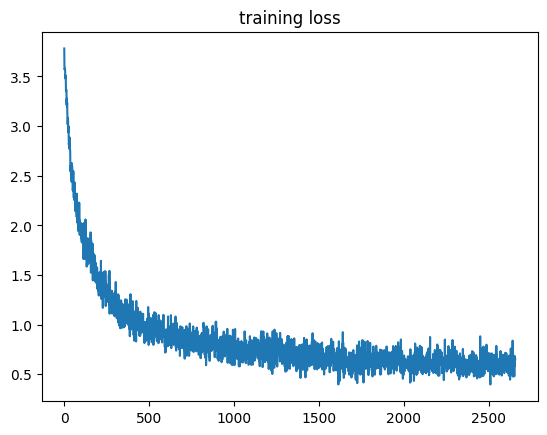

In [ ]:
# Let's plot the training loss versus the number of iteration.
plt.plot(losses);
plt.title("training loss");

In [ ]:
def predict(tensor):
    # Use the model to predict the label of the waveform
    tensor = tensor.to(device)
    tensor = transform(tensor)
    tensor = model(tensor.unsqueeze(0))
    tensor = get_likely_index(tensor)
    tensor = index_to_label(tensor.squeeze())
    return tensor


waveform, sample_rate, utterance, *_ = train_set[-1]
ipd.Audio(waveform.numpy(), rate=sample_rate)

print(f"Expected: {utterance}. Predicted: {predict(waveform)}.")

Expected: zero. Predicted: zero.


Let’s find an example that isn’t classified correctly, if there is one.




In [ ]:
for i, (waveform, sample_rate, utterance, *_) in enumerate(test_set):
    output = predict(waveform)
    if output != utterance:
        ipd.Audio(waveform.numpy(), rate=sample_rate)
        print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")
        break
else:
    print("All examples in this dataset were correctly classified!")
    print("In this case, let's just look at the last data point")
    ipd.Audio(waveform.numpy(), rate=sample_rate)
    print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")

Data point #1. Expected: right. Predicted: nine.


Feel free to try with one of your own recordings of one of the labels!
For example, using Colab, say “Go” while executing the cell below. This
will record one second of audio and try to classify it.




In [ ]:
def record(seconds=1):

    from google.colab import output as colab_output
    from base64 import b64decode
    from io import BytesIO
    from pydub import AudioSegment

    RECORD = (
        b"const sleep  = time => new Promise(resolve => setTimeout(resolve, time))\n"
        b"const b2text = blob => new Promise(resolve => {\n"
        b"  const reader = new FileReader()\n"
        b"  reader.onloadend = e => resolve(e.srcElement.result)\n"
        b"  reader.readAsDataURL(blob)\n"
        b"})\n"
        b"var record = time => new Promise(async resolve => {\n"
        b"  stream = await navigator.mediaDevices.getUserMedia({ audio: true })\n"
        b"  recorder = new MediaRecorder(stream)\n"
        b"  chunks = []\n"
        b"  recorder.ondataavailable = e => chunks.push(e.data)\n"
        b"  recorder.start()\n"
        b"  await sleep(time)\n"
        b"  recorder.onstop = async ()=>{\n"
        b"    blob = new Blob(chunks)\n"
        b"    text = await b2text(blob)\n"
        b"    resolve(text)\n"
        b"  }\n"
        b"  recorder.stop()\n"
        b"})"
    )
    RECORD = RECORD.decode("ascii")

    print(f"Recording started for {seconds} seconds.")
    display(ipd.Javascript(RECORD))
    s = colab_output.eval_js("record(%d)" % (seconds * 1000))
    print("Recording ended.")
    b = b64decode(s.split(",")[1])

    fileformat = "wav"
    filename = f"_audio.{fileformat}"
    AudioSegment.from_file(BytesIO(b)).export(filename, format=fileformat)
    return torchaudio.load(filename)


# Detect whether notebook runs in google colab
if "google.colab" in sys.modules:
    waveform, sample_rate = record()
    print(f"Predicted: {predict(waveform)}.")
    ipd.Audio(waveform.numpy(), rate=sample_rate)

In [ ]:
torch.save(model.state_dict(), '/content/m5_speech_commands.pth')

In [ ]:
!pip install rarfile

In [ ]:
import rarfile
import os

def extract_rar(rar_path, extract_to):
    # Ensure the extract directory exists
    if not os.path.exists(extract_to):
        os.makedirs(extract_to)

    # Open and extract the .rar file
    with rarfile.RarFile(rar_path) as rf:
        rf.extractall(path=extract_to)

    print(f"Extracted to {extract_to}")

# Path to your .rar file and where to extract
rar_file_path = "/content/recordings_v2.rar"
extract_to_path = "/content"

# Extract the .rar file
extract_rar(rar_file_path, extract_to_path)


Extracted to /content


In [ ]:
import torchaudio
from torchaudio.datasets import SPEECHCOMMANDS
import os
from torchaudio.transforms import Resample

class CustomSpeechCommands(SPEECHCOMMANDS):
    def __init__(self, subset: str = None, dataset_path: str = "./", target_sample_rate: int = 16000):
        super().__init__(dataset_path, download=False)
        self.target_sample_rate = target_sample_rate

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]

    def __getitem__(self, n):
        # Load the waveform, sample rate, and metadata
        fileid = self._walker[n]
        waveform, sample_rate = torchaudio.load(fileid)

        # Resample if necessary
        if sample_rate != self.target_sample_rate:
            resampler = Resample(orig_freq=sample_rate, new_freq=self.target_sample_rate)
            waveform = resampler(waveform)

        label = os.path.basename(os.path.dirname(fileid))
        speaker_id = fileid.split("/")[-2]  # Extract speaker ID from path
        utterance_number = int(os.path.basename(fileid).split("_")[-1].split(".")[0])

        return waveform, self.target_sample_rate, label, speaker_id, utterance_number

# Specify the path to your local dataset folder and target sample rate
local_dataset_path = "/content/recordings"
target_sample_rate = 16000

# Create training and testing split using the local folder and resampling
train_set = CustomSpeechCommands("training", dataset_path=local_dataset_path, target_sample_rate=target_sample_rate)
test_set = CustomSpeechCommands("testing", dataset_path=local_dataset_path, target_sample_rate=target_sample_rate)

# Example usage: access the first sample
waveform, sample_rate, label, speaker_id, utterance_number = train_set[-1]


Shape of waveform: torch.Size([2, 34475])
Sample rate of waveform: 16000
Label of waveform: zero


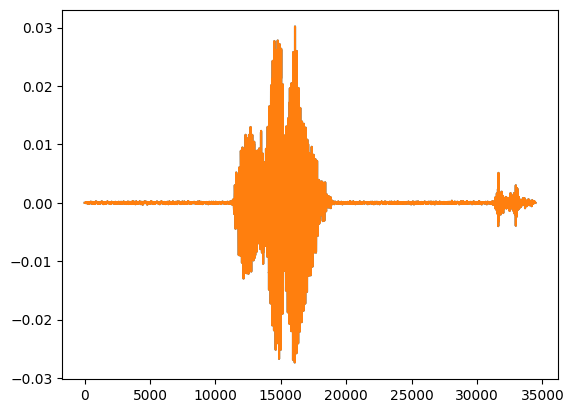

In [ ]:
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))
print("Label of waveform: {}".format(label))

plt.plot(waveform.t().numpy());

In [ ]:
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform)

ipd.Audio(transformed.numpy(), rate=new_sample_rate)

In [ ]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

yes --> tensor(33) --> yes


In [ ]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 10

if device == "cuda":
    num_workers = 16
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

In [ ]:
# Load pre-trained model
model = M5(n_input=1, n_output=len(labels))  # Adjust n_input and n_output based on your task
model.load_state_dict(torch.load('/content/m5_speech_commands.pth'))
model.to(device)
model.eval()  # Set the model to evaluation mode


M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=35, bias=True)
)

In [ ]:
# Freeze all layers except the final fully connected layer
for param in model.parameters():
    param.requires_grad = False

for param in model.fc1.parameters():  # Unfreeze the final layer for training
    param.requires_grad = True


In [ ]:
import torch.optim as optim
import torch.nn as nn

criterion = nn.CrossEntropyLoss()  # Adjust if needed
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Lower learning rate for fine-tuning


In [ ]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
labels


['backward',
 'bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'follow',
 'forward',
 'four',
 'go',
 'happy',
 'house',
 'learn',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'visual',
 'wow',
 'yes',
 'zero']

  0%|          | 0.043478260869565216/16 [00:00<01:13,  4.63s/it]

Train Epoch: 1 [0/535 (0%)]	Loss: 1.323103


  1%|          | 0.1884057971014493/16 [00:00<01:08,  4.34s/it] 

Train Epoch: 1 [100/535 (19%)]	Loss: 1.900123


  2%|▏         | 0.3333333333333334/16 [00:01<01:23,  5.35s/it]

Train Epoch: 1 [200/535 (37%)]	Loss: 0.660024


  3%|▎         | 0.4782608695652176/16 [00:02<01:26,  5.58s/it] 

Train Epoch: 1 [300/535 (56%)]	Loss: 1.570910


  4%|▍         | 0.6231884057971012/16 [00:03<01:24,  5.50s/it]

Train Epoch: 1 [400/535 (74%)]	Loss: 1.257939


  5%|▍         | 0.7681159420289848/16 [00:03<01:01,  4.04s/it]

Train Epoch: 1 [500/535 (93%)]	Loss: 0.829635


  6%|▋         | 1.0289855072463754/16 [00:04<00:53,  3.58s/it]


Test Epoch: 1	Accuracy: 87/145 (60%)

Train Epoch: 2 [0/535 (0%)]	Loss: 0.705284


  8%|▊         | 1.202898550724637/16 [00:05<00:54,  3.71s/it]

Train Epoch: 2 [100/535 (19%)]	Loss: 1.447238


  8%|▊         | 1.3478260869565217/16 [00:05<00:54,  3.71s/it]

Train Epoch: 2 [200/535 (37%)]	Loss: 1.030103


  9%|▉         | 1.4927536231884064/16 [00:06<00:55,  3.83s/it]

Train Epoch: 2 [300/535 (56%)]	Loss: 0.582197


 10%|█         | 1.6376811594202911/16 [00:07<00:54,  3.80s/it]

Train Epoch: 2 [400/535 (74%)]	Loss: 1.266209


 11%|█         | 1.7971014492753643/16 [00:07<00:50,  3.58s/it]

Train Epoch: 2 [500/535 (93%)]	Loss: 1.407802


 13%|█▎        | 2.043478260869568/16 [00:08<00:51,  3.67s/it]


Test Epoch: 2	Accuracy: 91/145 (63%)

Train Epoch: 3 [0/535 (0%)]	Loss: 1.853072


 14%|█▎        | 2.1884057971014528/16 [00:09<00:52,  3.82s/it]

Train Epoch: 3 [100/535 (19%)]	Loss: 1.063182


 15%|█▍        | 2.3333333333333375/16 [00:09<00:53,  3.89s/it]

Train Epoch: 3 [200/535 (37%)]	Loss: 1.510522


 15%|█▌        | 2.478260869565222/16 [00:10<00:52,  3.91s/it] 

Train Epoch: 3 [300/535 (56%)]	Loss: 1.717840


 16%|█▋        | 2.623188405797107/16 [00:10<00:52,  3.93s/it]

Train Epoch: 3 [400/535 (74%)]	Loss: 0.926896


 17%|█▋        | 2.7681159420289916/16 [00:11<00:52,  3.97s/it]

Train Epoch: 3 [500/535 (93%)]	Loss: 0.561408


 19%|█▉        | 3.028985507246384/16 [00:12<00:48,  3.75s/it] 


Test Epoch: 3	Accuracy: 92/145 (63%)

Train Epoch: 4 [0/535 (0%)]	Loss: 1.805665


 20%|██        | 3.2028985507246457/16 [00:13<00:49,  3.90s/it]

Train Epoch: 4 [100/535 (19%)]	Loss: 0.304795


 21%|██        | 3.3188405797101534/16 [00:13<01:04,  5.05s/it]

Train Epoch: 4 [200/535 (37%)]	Loss: 0.303576


 22%|██▏       | 3.463768115942038/16 [00:14<01:11,  5.74s/it]

Train Epoch: 4 [300/535 (56%)]	Loss: 1.451659


 23%|██▎       | 3.608695652173923/16 [00:15<01:12,  5.87s/it]

Train Epoch: 4 [400/535 (74%)]	Loss: 0.955723


 24%|██▎       | 3.797101449275373/16 [00:16<00:51,  4.20s/it] 

Train Epoch: 4 [500/535 (93%)]	Loss: 0.752875


 25%|██▌       | 4.043478260869577/16 [00:17<00:46,  3.93s/it]


Test Epoch: 4	Accuracy: 105/145 (72%)

Train Epoch: 5 [0/535 (0%)]	Loss: 1.273694


 26%|██▌       | 4.188405797101462/16 [00:17<00:45,  3.84s/it]

Train Epoch: 5 [100/535 (19%)]	Loss: 0.860272


 27%|██▋       | 4.333333333333346/16 [00:18<00:46,  4.02s/it]

Train Epoch: 5 [200/535 (37%)]	Loss: 0.894993


 28%|██▊       | 4.478260869565231/16 [00:18<00:45,  3.99s/it]

Train Epoch: 5 [300/535 (56%)]	Loss: 0.823298


 29%|██▉       | 4.623188405797116/16 [00:19<00:44,  3.95s/it]

Train Epoch: 5 [400/535 (74%)]	Loss: 0.835765


 30%|██▉       | 4.7681159420290005/16 [00:20<00:43,  3.91s/it]

Train Epoch: 5 [500/535 (93%)]	Loss: 0.828963


 32%|███▏      | 5.043478260869581/16 [00:21<00:41,  3.78s/it] 


Test Epoch: 5	Accuracy: 110/145 (76%)

Train Epoch: 6 [0/535 (0%)]	Loss: 0.566372


 32%|███▏      | 5.188405797101466/16 [00:21<00:41,  3.84s/it]

Train Epoch: 6 [100/535 (19%)]	Loss: 1.028032


 33%|███▎      | 5.333333333333351/16 [00:22<00:41,  3.93s/it]

Train Epoch: 6 [200/535 (37%)]	Loss: 1.050523


 34%|███▍      | 5.4782608695652355/16 [00:22<00:40,  3.81s/it]

Train Epoch: 6 [300/535 (56%)]	Loss: 0.519003


 35%|███▌      | 5.62318840579712/16 [00:23<00:42,  4.05s/it] 

Train Epoch: 6 [400/535 (74%)]	Loss: 0.545253


 36%|███▌      | 5.768115942029005/16 [00:23<00:39,  3.90s/it]

Train Epoch: 6 [500/535 (93%)]	Loss: 0.898815


 38%|███▊      | 6.028985507246397/16 [00:24<00:35,  3.56s/it]


Test Epoch: 6	Accuracy: 111/145 (77%)

Train Epoch: 7 [0/535 (0%)]	Loss: 0.505398


 39%|███▉      | 6.202898550724659/16 [00:25<00:36,  3.73s/it]

Train Epoch: 7 [100/535 (19%)]	Loss: 0.552505


 40%|███▉      | 6.333333333333355/16 [00:26<00:43,  4.46s/it]

Train Epoch: 7 [200/535 (37%)]	Loss: 1.183349


 40%|████      | 6.47826086956524/16 [00:26<00:49,  5.18s/it] 

Train Epoch: 7 [300/535 (56%)]	Loss: 0.709548


 41%|████▏     | 6.623188405797125/16 [00:27<00:51,  5.52s/it]

Train Epoch: 7 [400/535 (74%)]	Loss: 0.770277


 42%|████▏     | 6.768115942029009/16 [00:28<00:50,  5.47s/it]

Train Epoch: 7 [500/535 (93%)]	Loss: 1.283567


 44%|████▍     | 7.04347826086959/16 [00:29<00:32,  3.67s/it] 


Test Epoch: 7	Accuracy: 113/145 (78%)

Train Epoch: 8 [0/535 (0%)]	Loss: 0.347103


 45%|████▍     | 7.188405797101475/16 [00:29<00:31,  3.62s/it]

Train Epoch: 8 [100/535 (19%)]	Loss: 0.641143


 46%|████▌     | 7.33333333333336/16 [00:30<00:32,  3.80s/it] 

Train Epoch: 8 [200/535 (37%)]	Loss: 1.034464


 47%|████▋     | 7.478260869565244/16 [00:31<00:32,  3.82s/it]

Train Epoch: 8 [300/535 (56%)]	Loss: 1.046340


 48%|████▊     | 7.623188405797129/16 [00:31<00:31,  3.79s/it]

Train Epoch: 8 [400/535 (74%)]	Loss: 0.270207


 49%|████▊     | 7.768115942029014/16 [00:32<00:32,  3.97s/it]

Train Epoch: 8 [500/535 (93%)]	Loss: 1.177444


 50%|█████     | 8.028985507246404/16 [00:33<00:29,  3.75s/it]


Test Epoch: 8	Accuracy: 116/145 (80%)

Train Epoch: 9 [0/535 (0%)]	Loss: 1.482112


 51%|█████▏    | 8.202898550724655/16 [00:33<00:29,  3.82s/it]

Train Epoch: 9 [100/535 (19%)]	Loss: 0.201966


 52%|█████▏    | 8.34782608695653/16 [00:34<00:29,  3.87s/it] 

Train Epoch: 9 [200/535 (37%)]	Loss: 0.352158


 53%|█████▎    | 8.492753623188406/16 [00:34<00:28,  3.86s/it]

Train Epoch: 9 [300/535 (56%)]	Loss: 0.400531


 54%|█████▍    | 8.637681159420282/16 [00:35<00:29,  4.01s/it]

Train Epoch: 9 [400/535 (74%)]	Loss: 1.073570


 55%|█████▍    | 8.797101449275345/16 [00:36<00:26,  3.63s/it]

Train Epoch: 9 [500/535 (93%)]	Loss: 0.738163


 57%|█████▋    | 9.043478260869534/16 [00:37<00:26,  3.75s/it]


Test Epoch: 9	Accuracy: 122/145 (84%)

Train Epoch: 10 [0/535 (0%)]	Loss: 0.242371


 57%|█████▋    | 9.18840579710141/16 [00:37<00:26,  3.94s/it] 

Train Epoch: 10 [100/535 (19%)]	Loss: 0.362244


 58%|█████▊    | 9.333333333333286/16 [00:38<00:27,  4.08s/it]

Train Epoch: 10 [200/535 (37%)]	Loss: 0.369067


 59%|█████▉    | 9.478260869565162/16 [00:39<00:35,  5.39s/it]

Train Epoch: 10 [300/535 (56%)]	Loss: 0.215206


 60%|██████    | 9.623188405797038/16 [00:39<00:37,  5.83s/it]

Train Epoch: 10 [400/535 (74%)]	Loss: 0.297259


 61%|██████    | 9.768115942028913/16 [00:40<00:36,  5.84s/it]

Train Epoch: 10 [500/535 (93%)]	Loss: 0.753640


 63%|██████▎   | 10.043478260869477/16 [00:41<00:23,  3.86s/it]


Test Epoch: 10	Accuracy: 124/145 (86%)

Train Epoch: 11 [0/535 (0%)]	Loss: 0.638082


 64%|██████▎   | 10.188405797101353/16 [00:42<00:23,  4.04s/it]

Train Epoch: 11 [100/535 (19%)]	Loss: 0.630875


 65%|██████▍   | 10.33333333333323/16 [00:43<00:22,  3.92s/it] 

Train Epoch: 11 [200/535 (37%)]	Loss: 0.753498


 65%|██████▌   | 10.478260869565105/16 [00:43<00:21,  3.89s/it]

Train Epoch: 11 [300/535 (56%)]	Loss: 0.169643


 66%|██████▋   | 10.62318840579698/16 [00:44<00:21,  3.93s/it] 

Train Epoch: 11 [400/535 (74%)]	Loss: 0.527000


 67%|██████▋   | 10.768115942028857/16 [00:44<00:20,  3.95s/it]

Train Epoch: 11 [500/535 (93%)]	Loss: 0.488363


 69%|██████▉   | 11.028985507246233/16 [00:45<00:18,  3.78s/it]


Test Epoch: 11	Accuracy: 127/145 (88%)

Train Epoch: 12 [0/535 (0%)]	Loss: 0.500892


 70%|███████   | 11.202898550724484/16 [00:46<00:19,  3.99s/it]

Train Epoch: 12 [100/535 (19%)]	Loss: 0.682403


 71%|███████   | 11.34782608695636/16 [00:47<00:18,  3.97s/it] 

Train Epoch: 12 [200/535 (37%)]	Loss: 0.913325


 72%|███████▏  | 11.492753623188236/16 [00:47<00:17,  3.91s/it]

Train Epoch: 12 [300/535 (56%)]	Loss: 0.118145


 73%|███████▎  | 11.637681159420111/16 [00:48<00:17,  4.12s/it]

Train Epoch: 12 [400/535 (74%)]	Loss: 0.771734


 73%|███████▎  | 11.753623188405612/16 [00:48<00:18,  4.24s/it]

Train Epoch: 12 [500/535 (93%)]	Loss: 0.485344


 75%|███████▌  | 12.043478260869364/16 [00:49<00:14,  3.78s/it]


Test Epoch: 12	Accuracy: 125/145 (86%)

Train Epoch: 13 [0/535 (0%)]	Loss: 0.339032


 76%|███████▌  | 12.18840579710124/16 [00:50<00:14,  3.88s/it] 

Train Epoch: 13 [100/535 (19%)]	Loss: 0.773744


 77%|███████▋  | 12.333333333333115/16 [00:50<00:14,  3.92s/it]

Train Epoch: 13 [200/535 (37%)]	Loss: 0.626974


 78%|███████▊  | 12.478260869564991/16 [00:51<00:18,  5.16s/it]

Train Epoch: 13 [300/535 (56%)]	Loss: 0.790633


 79%|███████▉  | 12.623188405796867/16 [00:52<00:19,  5.67s/it]

Train Epoch: 13 [400/535 (74%)]	Loss: 0.718283


 80%|███████▉  | 12.768115942028743/16 [00:53<00:18,  5.84s/it]

Train Epoch: 13 [500/535 (93%)]	Loss: 0.696299


 82%|████████▏ | 13.043478260869307/16 [00:54<00:11,  4.01s/it]


Test Epoch: 13	Accuracy: 132/145 (91%)

Train Epoch: 14 [0/535 (0%)]	Loss: 0.636721


 82%|████████▏ | 13.188405797101183/16 [00:55<00:10,  3.84s/it]

Train Epoch: 14 [100/535 (19%)]	Loss: 0.582432


 83%|████████▎ | 13.333333333333059/16 [00:55<00:10,  3.78s/it]

Train Epoch: 14 [200/535 (37%)]	Loss: 0.428680


 84%|████████▍ | 13.478260869564934/16 [00:56<00:09,  3.84s/it]

Train Epoch: 14 [300/535 (56%)]	Loss: 0.421796


 85%|████████▌ | 13.62318840579681/16 [00:56<00:09,  3.95s/it] 

Train Epoch: 14 [400/535 (74%)]	Loss: 0.163321


 86%|████████▌ | 13.768115942028686/16 [00:57<00:08,  3.95s/it]

Train Epoch: 14 [500/535 (93%)]	Loss: 0.367478


 88%|████████▊ | 14.028985507246063/16 [00:58<00:07,  3.69s/it]


Test Epoch: 14	Accuracy: 133/145 (92%)

Train Epoch: 15 [0/535 (0%)]	Loss: 0.471180


 89%|████████▉ | 14.202898550724314/16 [00:58<00:07,  4.00s/it]

Train Epoch: 15 [100/535 (19%)]	Loss: 0.629109


 90%|████████▉ | 14.34782608695619/16 [00:59<00:06,  4.03s/it] 

Train Epoch: 15 [200/535 (37%)]	Loss: 0.189428


 91%|█████████ | 14.492753623188065/16 [01:00<00:06,  4.06s/it]

Train Epoch: 15 [300/535 (56%)]	Loss: 0.183415


 91%|█████████▏| 14.637681159419941/16 [01:00<00:05,  3.81s/it]

Train Epoch: 15 [400/535 (74%)]	Loss: 0.261172


 92%|█████████▏| 14.753623188405442/16 [01:01<00:04,  3.97s/it]

Train Epoch: 15 [500/535 (93%)]	Loss: 0.316950


 94%|█████████▍| 15.043478260869193/16 [01:02<00:03,  3.80s/it]


Test Epoch: 15	Accuracy: 131/145 (90%)

Train Epoch: 16 [0/535 (0%)]	Loss: 0.653405


 95%|█████████▍| 15.188405797101069/16 [01:02<00:03,  3.81s/it]

Train Epoch: 16 [100/535 (19%)]	Loss: 0.294380


 96%|█████████▌| 15.333333333332945/16 [01:03<00:02,  3.92s/it]

Train Epoch: 16 [200/535 (37%)]	Loss: 0.273168


 97%|█████████▋| 15.47826086956482/16 [01:04<00:02,  4.93s/it] 

Train Epoch: 16 [300/535 (56%)]	Loss: 0.304271


 98%|█████████▊| 15.623188405796697/16 [01:04<00:02,  5.38s/it]

Train Epoch: 16 [400/535 (74%)]	Loss: 0.230182


 99%|█████████▊| 15.768115942028572/16 [01:05<00:01,  5.52s/it]

Train Epoch: 16 [500/535 (93%)]	Loss: 0.131387


100%|█████████▉| 15.999999999999574/16 [01:06<00:00,  4.17s/it]



Test Epoch: 16	Accuracy: 130/145 (90%)



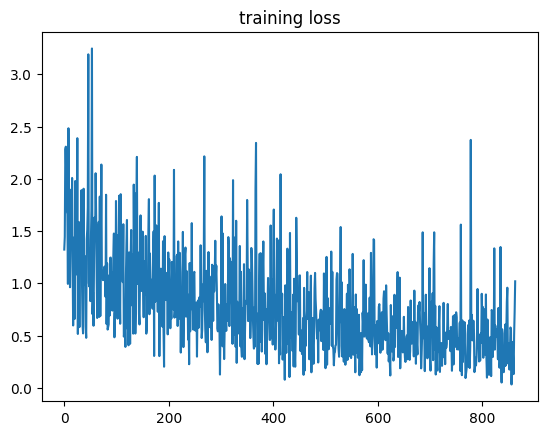

In [ ]:
model.train()  # Set the model to training mode

log_interval = 10
n_epoch = 16

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        test(model, epoch)
        scheduler.step()

# Let's plot the training loss versus the number of iteration.
plt.plot(losses);
plt.title("training loss");
